In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import nolds
import pywt

from glassnode import *
from statsmodels.tsa.stattools import adfuller
from stqdm import stqdm

import statsmodels.api as sm
from scipy.stats import mode
from scipy import signal

from tqdm.notebook import tqdm

plt.rcParams['figure.figsize'] = [20,12]
sns.set()

In [51]:
def strided_app(a, L, S ):  # Window len = L, Stride len/stepsize = S
    nrows = ((a.size-L)//S)+1
    n = a.strides[0]
    return np.lib.stride_tricks.as_strided(a, shape=(nrows,L), strides=(S*n,n))

In [52]:
def get_glassnode_price():
    GLASSNODE_API_KEY = '1vUcyF35hTk9awbNGszF0KcLuYH'

    self = GlassnodeClient()
    self.set_api_key(GLASSNODE_API_KEY)

    url = URLS['Market'] + 'price_usd_ohlc'
    a ='BTC'
    c = 'native'
    i='24h'

    ohlc = self.get(url,a,i,c)
    return ohlc

In [53]:
ohlc = get_glassnode_price()
ohlc = ohlc.rename(columns = {'c':'close','h':'high','l':'low','o':'open'})

In [54]:
Px = ohlc[['high','low']].mean(axis = 1).rename('price')
px = np.log(Px)

R = px.diff()

In [55]:
def Rolling_Mode(x,L):
    x_strided = strided_app(x.values,L,1)
    x_mode = np.empty_like(x.values)
    x_mode[:] = np.nan
    x_mode[(L-1):] = [mode(x_strided[j,:])[0][0] for j in (range(x_strided.shape[0]))]
    x_mode = pd.Series(x_mode,index = x.index)
    return x_mode

def Rolling_Hurst(x,L,max_lag=20):
    x_strided = strided_app(x.values,L,1)
    x_hurst = np.empty_like(x.values)
    x_hurst[:] = np.nan
    x_hurst[(L-1):] = [get_hurst_exponent(x_strided[j,:],max_lag=max_lag) for j in range(x_strided.shape[0])]
    x_hurst = pd.Series(x_hurst,index = x.index)
    return x_hurst


def Rolling_DFA(x,L):
    x_strided = strided_app(x.values,L,1)
    x_hurst = np.empty_like(x.values)
    x_hurst[:] = np.nan
    x_hurst[(L-1):] = [nolds.dfa(x_strided[j,:]) for j in tqdm(range(x_strided.shape[0]))]
    x_hurst = pd.Series(x_hurst,index = x.index)
    return x_hurst

def get_hurst_exponent(time_series, max_lag=20):
    """Returns the Hurst Exponent of the time series"""
    
    lags = range(2, max_lag)

    # variances of the lagged differences
    tau = [np.std(np.subtract(time_series[lag:], time_series[:-lag])) for lag in lags]

    # calculate the slope of the log plot -> the Hurst Exponent
    reg = np.polyfit(np.log(lags), np.log(tau), 1)

    return reg[0]


In [56]:
Price_roll_mode = Rolling_Mode(px,252)
Return_roll_mode = Rolling_Mode(R,252)
Price_roll_hurst = Rolling_Hurst(px,252,45)

In [58]:
cA, cD = pywt.dwt(px, 'db1')

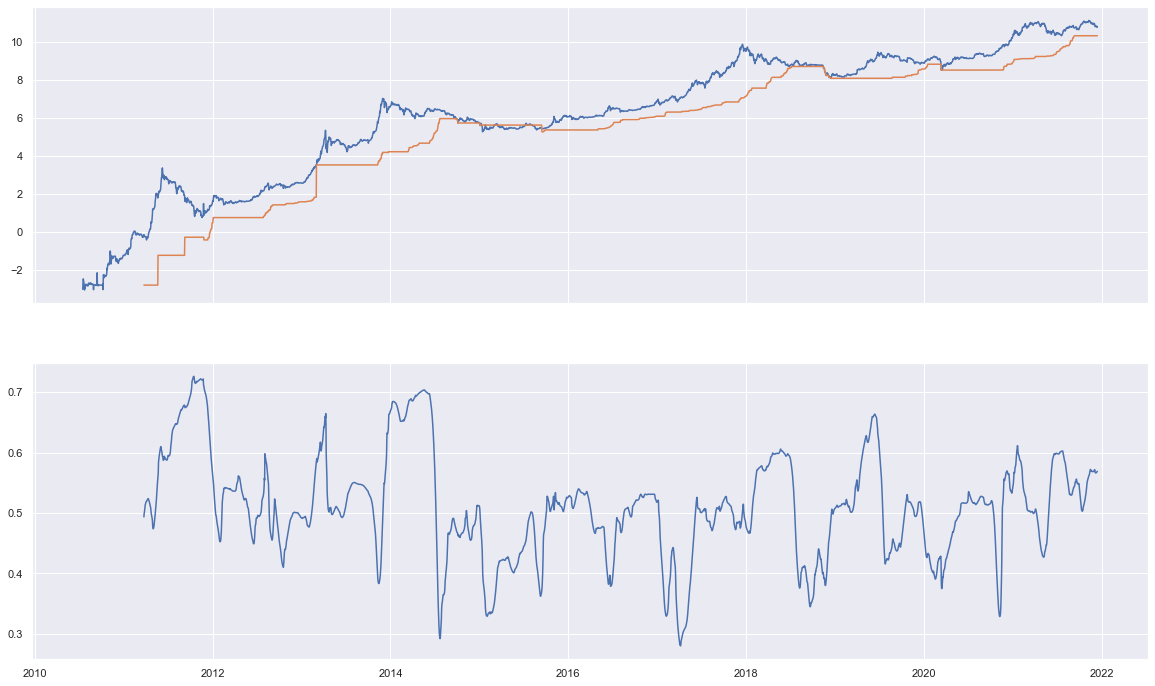

In [57]:
f,a = plt.subplots(nrows = 2, sharex = True)
a[0].plot(px)
a[0].plot(Price_roll_mode)
a[1].plot(Price_roll_hurst)

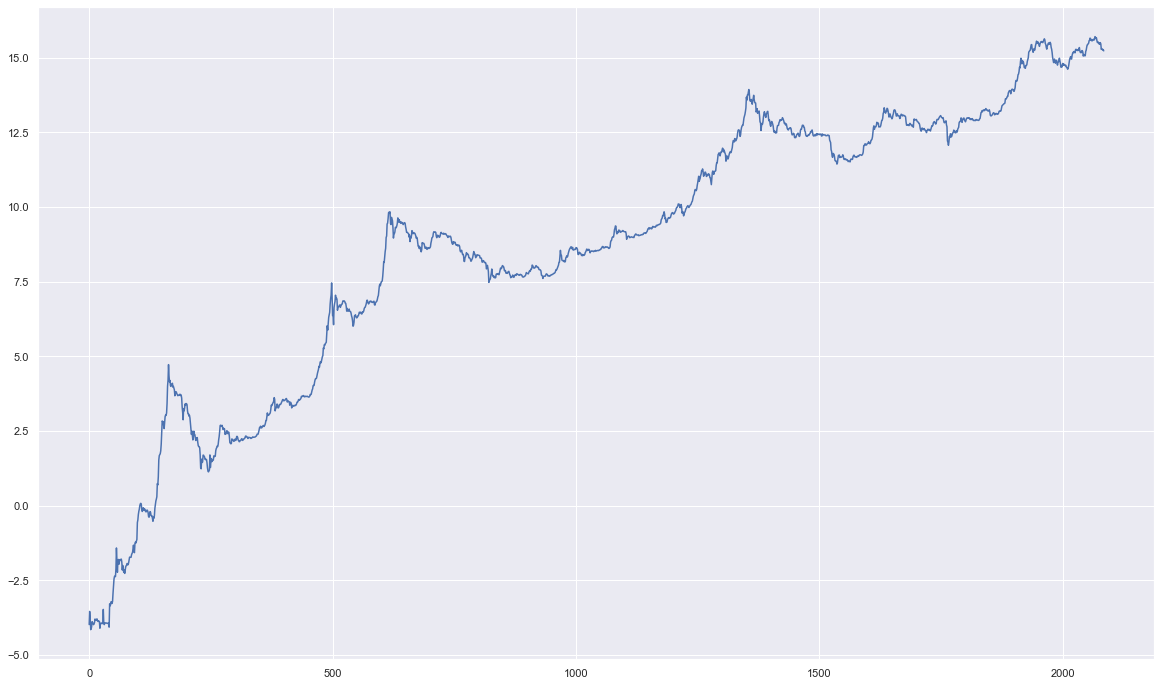

In [62]:
plt.plot(cA)

In [63]:
len(px)

4169